In [1]:
import librosa
from IPython.display import Audio
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchaudio
from torch.utils.data import DataLoader
import audiomentations
from sklearn.preprocessing import LabelEncoder
import torchaudio
import random
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift,SpecFrequencyMask
import torchvision
import cv2


## Configuration

In [2]:
class CONFIG:
    random_seed= 42
    
    sample_rate = 32000
    duration=10
    audio_len = duration*sample_rate
    target_len = duration*sample_rate
    
    img_size = [128,256]
    num_classes = 264
    batch_size = 32
    
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 500
    fmax = 14000
    normalize = True

    prob_fm = 0.45

    

## Load Data

In [3]:
# Load metadata
meta_train2023 = pd.read_csv("train_metadata.csv")
meta_train2023.head(5)
meta_train2023['filepath'] = './train_audio/'+meta_train2023['filename']
# Encode Labels
le = LabelEncoder()
meta_train2023['class'] = le.fit_transform(meta_train2023['primary_label'])

In [4]:
# load a audio sample randomly
random_loc = random.randint(0, len(meta_train2023))
au ,sr = librosa.load(meta_train2023['filepath'].iloc[random_loc] ,sr=None)
print(au.shape)
print(meta_train2023['scientific_name'].iloc[random_loc])
Audio(au,rate=sr)

(1112064,)
Apalis rufogularis


## Utilts
### Intro
* Crop or pad the audio tensor to a fixed length
* Apply some audio augmentations
* Extract Melspectrogram from auio tensor
* Apply some spectrogram augmentations
* Normalize spectrogram

In [5]:
def crop_or_pad(audio, target_len = CONFIG.target_len
                , pad_mode='constant', take_first=True):
    audio_len = audio.shape[0]
    diff_len = abs(target_len - audio_len)
    if audio_len < target_len:
        # padding audio tensor at a random start point
        pad1 = torch.randint(high=diff_len, size=[], dtype=torch.int32)
        pad2 = diff_len - pad1
        audio = torch.nn.functional.pad(audio, (pad1.item(), pad2.item()), mode=pad_mode)
    elif audio_len > target_len:
        if take_first:
            audio = audio[:target_len]
        else:
            idx = torch.randint(high=diff_len, size=[], dtype=torch.int32)
            audio = audio[idx.item(): (idx.item() + target_len)]
    return torch.reshape(audio, [target_len])

def audio_augment(audio):
    augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.35),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.45),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.45),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.45),
    ])
    audio = audio.numpy()
    aug_audio = augment(samples=audio, sample_rate=CONFIG.sample_rate)
    return torch.tensor(aug_audio)


def get_spectrogram(audio):
    audio = audio.numpy()
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CONFIG.sample_rate, 
                                   n_mels=CONFIG.img_size[0],
                                   n_fft=CONFIG.nfft,
                                   hop_length=CONFIG.hop_length,
                                   fmax=CONFIG.fmax,
                                   fmin=CONFIG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    return torch.tensor(spec).reshape((1, spec.shape[0],spec.shape[1]))


def spec_augmentation(spec):
    # TimeFrequencyMask
    #  Add random factor to Frequency Masking
    rand_prob = float(torch.rand(1))
    transfom1 = torchaudio.transforms.FrequencyMasking(freq_mask_param=10)
    transfom2 = torchaudio.transforms.TimeMasking(time_mask_param=25,p=0.5)
    if rand_prob >= CONFIG.prob_fm:
        spec = transfom1(spec)
        spec = transfom2(spec)
    else:
        spec = transfom2(spec)
    return spec

def spec_norm(mel_spectrogram):
    mel_spectrogram = mel_spectrogram[0]
    mean = torch.mean(mel_spectrogram, dim=1)
    std = torch.std(mel_spectrogram, dim=1)
    # Expand the mean and standard deviation tensors to have the same shape as the original spectrogram
    mean = mean.unsqueeze(1).expand_as(mel_spectrogram)
    std = std.unsqueeze(1).expand_as(mel_spectrogram)

    # Normalize the spectrogram by subtracting the mean and dividing by the standard deviation
    normalized_mel_spectrogram = (mel_spectrogram - mean) / std

    # You can also apply additional operations such as clipping or scaling if desired
    # For example, to clip the normalized spectrogram to a specific range, you can use torch.clamp:
    min_value = 0.0
    max_value = 1.0
    h = mel_spectrogram.shape[0]
    w = mel_spectrogram.shape[1]
    normalized_mel_spectrogram = torch.clamp(normalized_mel_spectrogram, min=min_value, max=max_value)
    return normalized_mel_spectrogram.reshape((1,h,w))




### utils demo


In [6]:
# Fix length
fixed_au = crop_or_pad(torch.tensor(au))
print(len(fixed_au))
Audio(fixed_au,rate=32000)

320000


In [7]:
# Audio Augmentations
au_aug = audio_augment(fixed_au)
Audio(au_aug,rate=32000)

In [8]:
# Extract Melspectrogram
au2spec = get_spectrogram(au_aug)
print(au2spec.shape)

torch.Size([1, 128, 256])


In [9]:
au2spec_aug =  spec_augmentation(au2spec)
print(au2spec_aug.shape)

torch.Size([1, 128, 256])


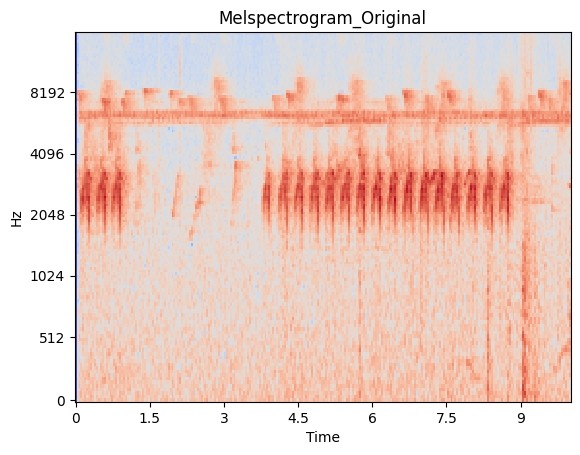

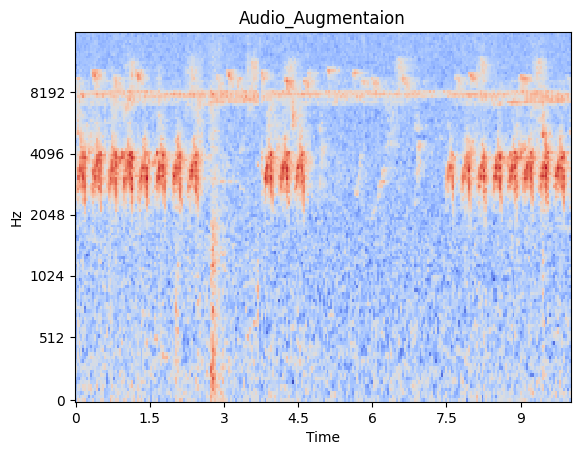

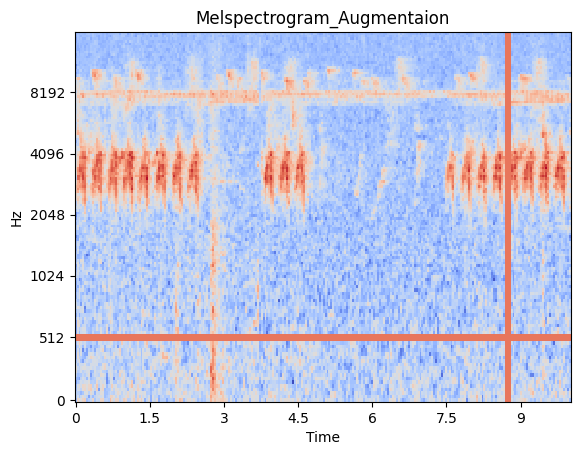

In [10]:
import librosa.display as lid
plt.title("Melspectrogram_Original")
lid.specshow(get_spectrogram(fixed_au)[0].numpy(), 
             n_fft=CONFIG.nfft, 
             hop_length=CONFIG.hop_length, 
             sr=CONFIG.sample_rate,
            x_axis='time',
            y_axis='mel',
            cmap='coolwarm')
plt.show()

plt.title("Audio_Augmentaion")
lid.specshow(au2spec[0].numpy(), 
             n_fft=CONFIG.nfft, 
             hop_length=CONFIG.hop_length, 
             sr=CONFIG.sample_rate,
            x_axis='time',
            y_axis='mel',
            cmap='coolwarm')
plt.show()


plt.title("Melspectrogram_Augmentaion")
lid.specshow(au2spec_aug[0].numpy(), 
             n_fft=CONFIG.nfft, 
             hop_length=CONFIG.hop_length, 
             sr=CONFIG.sample_rate,
            x_axis='time',
            y_axis='mel',
            cmap='coolwarm')
plt.show()

In [12]:
spec_norm_ = spec_norm(au2spec_aug)

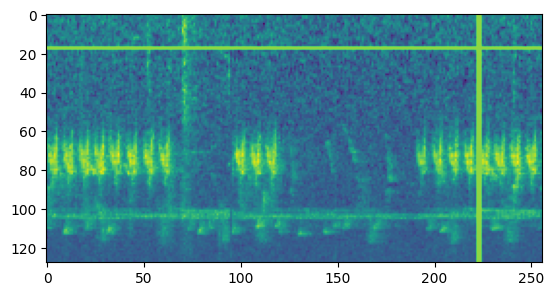

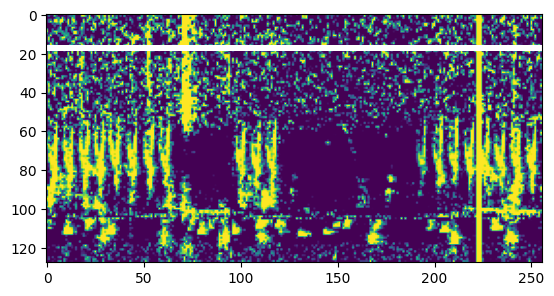

In [13]:
plt.imshow(au2spec_aug[0])
plt.show()
plt.imshow(spec_norm_[0]) 
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


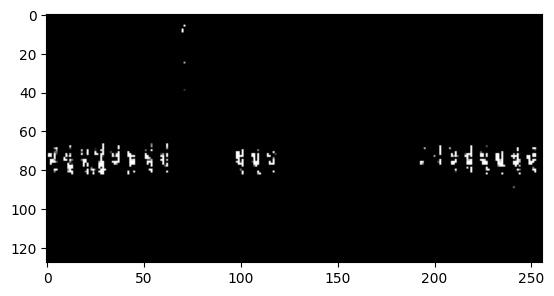

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


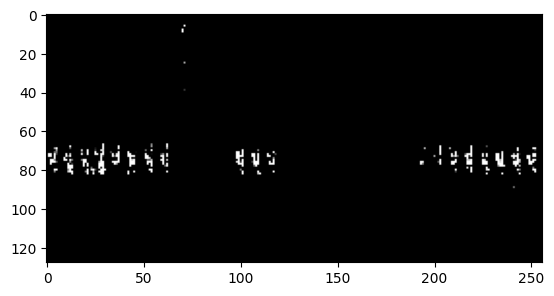

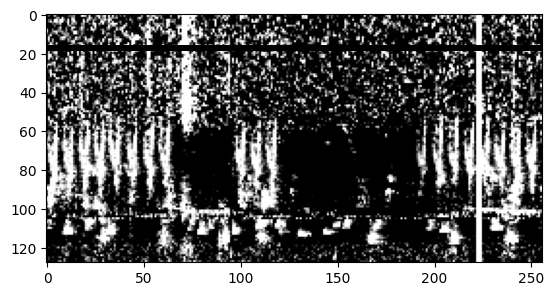

In [14]:
# convert grayscale image into RGB
spec2img_og = cv2.cvtColor(au2spec[0].numpy(), cv2.COLOR_GRAY2RGB)
spec2img_aug = cv2.cvtColor(au2spec_aug[0].numpy(), cv2.COLOR_GRAY2RGB)
spec2img_norm_aug = cv2.cvtColor(spec_norm_[0].numpy(), cv2.COLOR_GRAY2RGB)


plt.imshow(spec2img_og)
plt.show()
plt.imshow(spec2img_aug)
plt.show()
plt.imshow(spec2img_norm_aug)
plt.show()

## Create Dataset

In [15]:
from torch.nn.functional import one_hot
class AudioDataset(Dataset):
    def __init__(self,audio_df, transform=None, is_train=True):
        self.audio_df = audio_df
        self.transform = transform
        self.is_train = is_train
    def __len__(self):
        return len(self.audio_df)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        audio_path = self.audio_df['filepath'].iloc[idx]
        label = self.audio_df['class'].iloc[idx]
        audio,sr = librosa.load(audio_path,sr=None)
        audio = torch.tensor(audio)
        audio = crop_or_pad(audio)
        label_1hot = one_hot(torch.tensor(label), num_classes=CONFIG.num_classes)
        if self.is_train:
            audio= audio_augment(audio)
        # Spectrumgram Augmentations
        spec = get_spectrogram(audio)
        if self.is_train:
            spec = spec_augmentation(spec).reshape((1, spec[0].shape[0], 
            spec[0].shape[1]))
        # resize Spectrumgram
        resize = torchvision.transforms.Resize(CONFIG.img_size)
        spec =  resize(spec)
        # Normalize
        spec =spec_norm(spec)[0]
        # Conver GRAY into RGB
        spec_img = torch.tensor(cv2.cvtColor(spec.numpy()
    , cv2.COLOR_GRAY2RGB), dtype=float)
        sample  = {'img':spec_img,'label':label_1hot}
        if self.transform:
            sample = self.transform(sample)
        return spec_img, label_1hot

In [16]:
dataset  =  AudioDataset(meta_train2023)

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


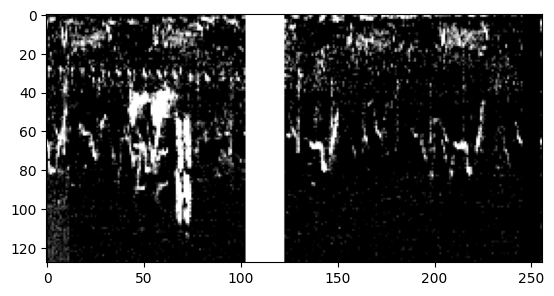

In [19]:
for i  in dataset:
    plt.imshow(i[0])
    print(i[1])
    break

## Data Split

In [20]:
from sklearn.model_selection import StratifiedKFold
seed = CONFIG.random_seed

# Initialize the StratifiedKFold object with 5 splits and shuffle the data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
# Reset the index of the dataframe
meta_train2023 = meta_train2023.reset_index(drop=True)

# Create a new column in the dataframe to store the fold number for each row
meta_train2023["fold"] = -1

# Iterate over the folds and assign the corresponding fold number to each row in the dataframe
for fold, (train_idx, val_idx) in enumerate(skf.split(meta_train2023, 
meta_train2023['primary_label'])):
    meta_train2023.loc[val_idx, 'fold'] = fold


/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [21]:
def filter_data(df, thr=5):
    # Count the number of samples for each class
    counts = df.primary_label.value_counts()

    # Condition that selects classes with less than `thr` samples
    cond = df.primary_label.isin(counts[counts<thr].index.tolist())

    # Add a new column to select samples for cross validation
    df['cv'] = True

    # Set cv = False for those class where there is samples less than thr
    df.loc[cond, 'cv'] = False

    # Return the filtered dataframe
    return df

meta_train2023 = filter_data(meta_train2023, thr=5)

#### -oversample for minority class
def upsample_data(df, thr=20,seed=666):
    # get the class distribution
    class_dist = df['primary_label'].value_counts()

    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    up_dfs = []

    # loop through the undersampled classes and upsample them
    for c in down_classes:
        # get the dataframe for the current class
        class_df = df.query("primary_label==@c")
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=seed)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)
    
    return up_df
up_df = upsample_data(meta_train2023, thr=50,seed=CONFIG.random_seed)

In [22]:
train_df =up_df.query("fold!=4 | ~cv").reset_index(drop=True)
valid_df = up_df.query("fold==4 &cv").reset_index(drop=True)
train_df.shape,valid_df.shape

((17944, 16), (4264, 16))

In [23]:
training_data = AudioDataset(train_df, is_train=True)
valid_data = AudioDataset(valid_df, is_train=False)

In [24]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=True)

In [25]:
import torchvision.models as models
import torch.nn as nn
def build_model(pretrained=True, fine_tune=True, num_classes=CONFIG.num_classes):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b0(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=CONFIG.num_classes)
    return model

In [26]:
model = build_model(pretrained=True, fine_tune=True, num_classes=CONFIG.num_classes)

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
model 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [28]:
for i, (inputs, targets) in enumerate(train_dataloader):
    print(i)
    print(inputs)
    print(targets)
    break


/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0
tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.2125, 0.2125, 0.2125],
          [0.3336, 0.3336, 0.3336]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.2000, 0.2000, 0.2000],
          [0.0603, 0.0603, 0.0603],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000],
          [0.6411, 0.6411, 0.6411]],

         ...,

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.00

In [ ]:
hello wolrd